In [1]:
(require '[clojupyter.misc.helper :as helper])
(helper/add-dependencies '[criterium/criterium "0.4.6"])
(helper/add-dependencies '[metasoarous/oz "1.5.6"])

(require '[clojupyter.display :as display])
(require '[clojure.string :as str])
(require '[oz.notebook.clojupyter :as oz])
:ok

:ok

In [2]:
;; Load results after running:
;; lein test knitty.bench.deferred :benchmark
(def bench-result-filename  "/home/szopolis/work/knitty/.bench-results/xxx.edn")

#'user/bench-result-filename

In [3]:
(require 'criterium.core)  ;; required to read tagged structs
(def br (-> (slurp bench-result-filename) (read-string)))

#'user/br

In [4]:
(defn infer-kt-vs-md-category [test-id]
  (let [s (set test-id)
        kt? (s :kt)
        md? (s :md)
        knitty? (s :knitty)
        manifold? (s :manifold)]
    [(vec (remove #{:kt :md :knitty :manifold} test-id))
     (cond
       (and knitty? md?) :knitty-md       ;; knitty functions, but md deferreds
       (and manifold? kt?) :manifold-kt   ;; manifold functions, but knitty deferreds
       knitty? :knitty
       manifold? :manifold)]))

#'user/infer-kt-vs-md-category

In [5]:
(def gdata
  (for [r (:results br)
        :let [[ti cat] (infer-kt-vs-md-category (-> r :test-id))]]
    {:full_test_id ti
     :test (first ti)
     :mode (let [s (set ti)]
               (cond
                 (s :defer) :async
                 (s :value) :sync))
     :subtest (last ti)
     :category cat
     :value (-> r :mean first (* 1000000000))
    }
  ))

#'user/gdata

In [6]:
(defn render-test-result [t vs]
  (display/display
   (display/render-mime
    :application/vnd.vegalite.v5+json
    {:title t
     :data {:values vs}
     :mark :bar
     :height 400
     :autosize {:type "fit" :contains "padding" :resize true}
     :encoding {:x {:field :subtest, :sort nil}
                :y {:field :value :type :quantitative}
                :color {:field :category :type :nominal}
                :xOffset {:field :category,
                          :sort [:knitty :knitty-md :manifold-kt :manifold]}}})))

#'user/render-test-result

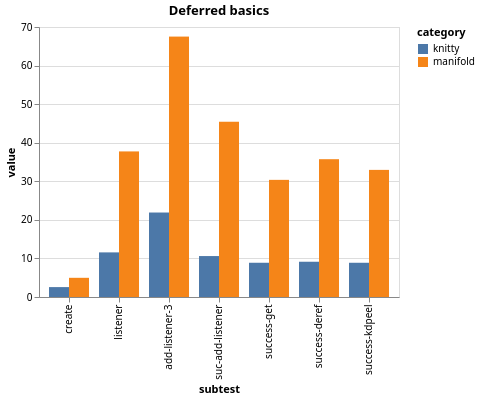

:ok

In [7]:
(render-test-result "Deferred basics" (filter #(= "bench-deferred" (:test %)) gdata))

test: benchmark-chain

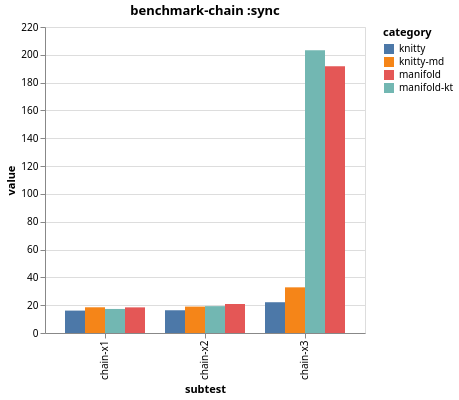

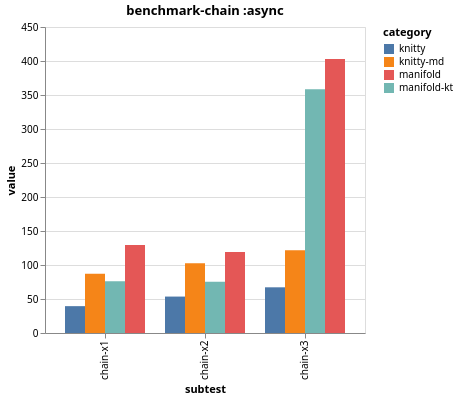

test: benchmark-chain-in

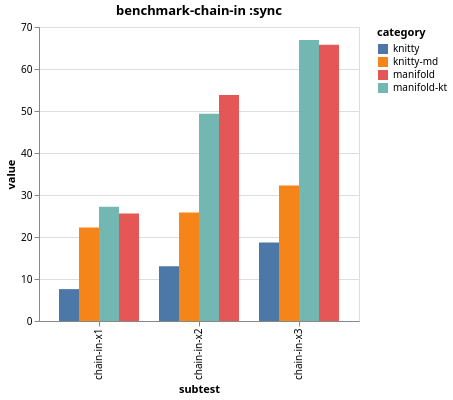

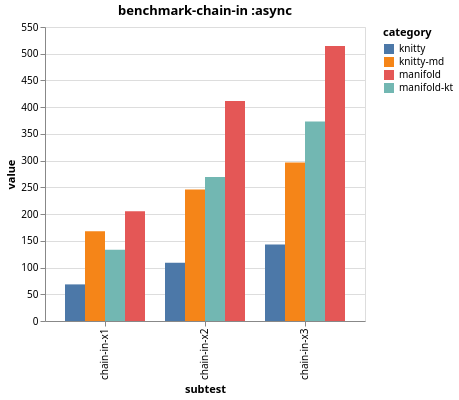

test: benchmark-chain-err

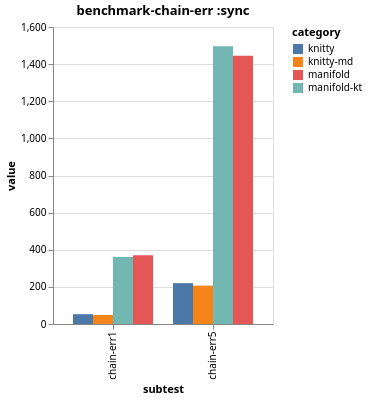

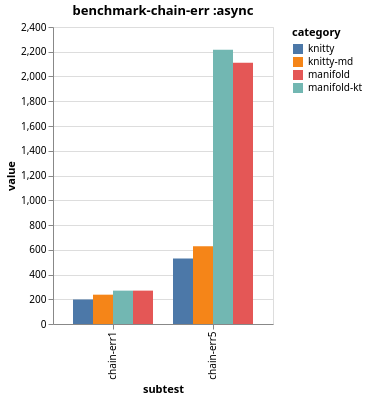

test: benchmark-alt

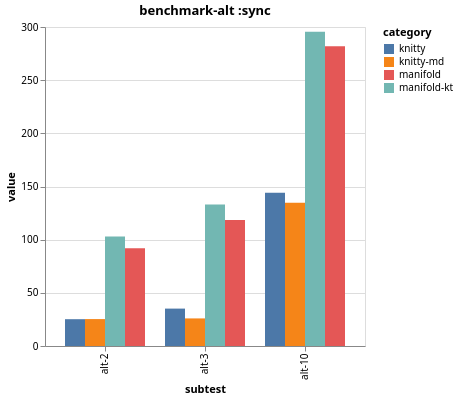

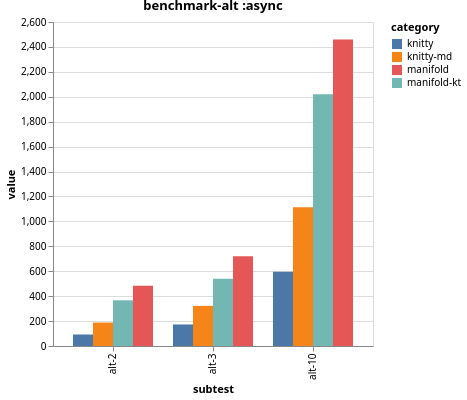

test: benchmark-zip

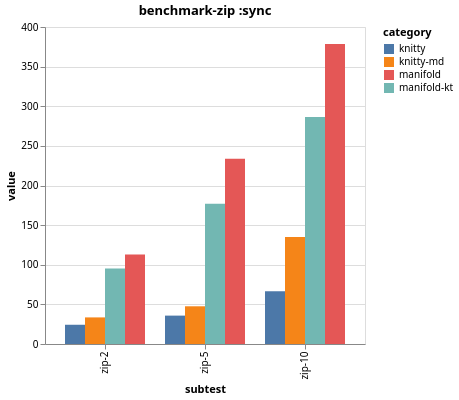

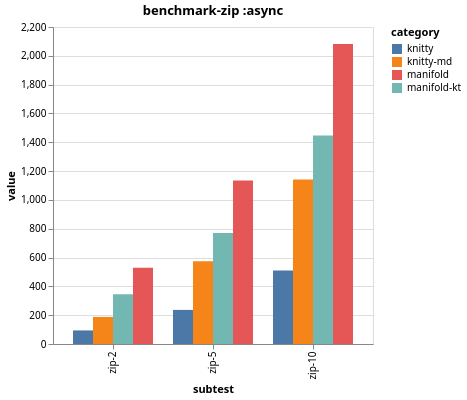

test: benchmark-zip-list

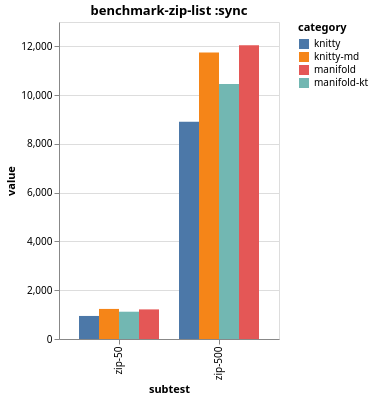

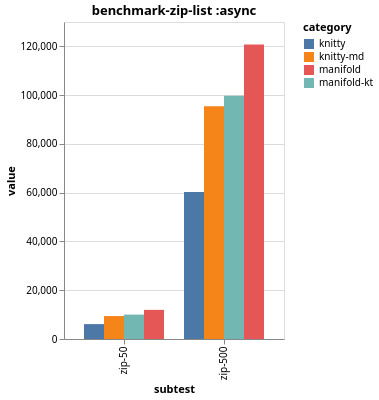

test: benchmark-loop

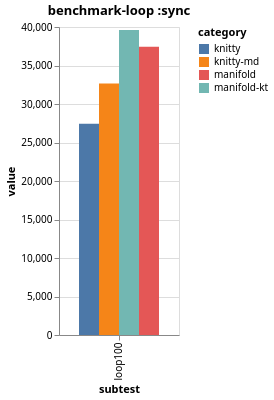

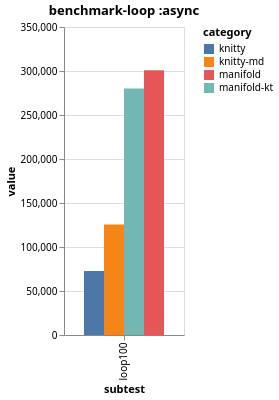

nil

In [8]:
(defn render-test [test mode]
  (render-test-result
   (str test (when mode (str " " mode)))
   (filter
    #(and (= test (:test %))
          (= mode (:mode %)))
    gdata)))

(doseq [t [
           "benchmark-chain"
           "benchmark-chain-in"
           "benchmark-chain-err"
           "benchmark-alt"
           "benchmark-zip"
           "benchmark-zip-list"
           "benchmark-loop"
           ]]
  (display/display (display/hiccup-html  [:h3 "test: " t]))
  (render-test t :sync)
  (render-test t :async))